In [59]:
### 4th implementation of MPC

### using the hexrotor ***
### using KF and wind model (set to 0 right now though...)

In [1]:
import Pkg
Pkg.activate(@__DIR__)
Pkg.instantiate()
using LinearAlgebra, Plots
import Convex as cvx 
import MeshCat as mc 
using Test
using Random
import Convex as cvx 
import ForwardDiff as FD
import ECOS  
using ProgressMeter    


  Activating environment at `c:\Users\scott\Documents\OCRL\MPCwZAC\Project.toml`


In [36]:
#include(joinpath(@__DIR__,"ref_traj.jl"))
# include(joinpath(@__DIR__,"planar_hexrotor_dynamics.jl"))
include(joinpath(@__DIR__,"tilted_hexrotor_dynamics.jl"))
#include(joinpath(@__DIR__,"quadrotor.jl"))

animate_hexrotor (generic function with 1 method)

In [3]:
######### utility functions
function create_ref_hover(model, N, dt, n_inputs, desired_altitude = 2)
    # create a hover reference (with no pitch) for whole time period
    mass = model.mass
    kf = model.kf

    # hover state
    hover_position = [0.0; 0.0; desired_altitude]  # Hover at (0, 0, 2)
    hover_velocity = [0.0; 0.0; 0.0]  # no velocity
    hover_attitude = [0.0; 0.0; 0.0]  # No roll, pitch, yaw
    hover_angvelocity= [0.0; 0.0; 0.0] # no angular velocity
    
    Xref= [zeros(12) for i = 1:N]
    #Xref[1]= x0
    for i= 1:N
        Xref[i]= [hover_position; hover_velocity; hover_attitude; hover_angvelocity]
    end

    Uref = [(9.81*mass/(n_inputs*kf))*ones(n_inputs) for i = 1:(N-1)]
    #Uref = [(9.81*mass)*ones(n_inputs) for i = 1:(N-1)]
    return Xref, Uref
end

function create_fig8(model, N, dt, n_inputs, radius)
    # create reference trajectory for quadrotor 
    R = radius
    mass = model.mass
    kf = model.kf
    Xref = [ [R*cos(t);R*cos(t)*sin(t);1.2 + sin(t);zeros(9)] 
        for t = range(-pi/2,3*pi/2, length = N)]
    for i = 1:(N-1)
        Xref[i][4:6] = (Xref[i+1][1:3] - Xref[i][1:3])/dt
    end
    Xref[N][4:6] = Xref[N-1][4:6]
    Uref = [(9.81*mass/(n_inputs*kf))*ones(n_inputs) for i = 1:(N-1)]
    return Xref, Uref
end

# converting to and from vector of vectors <-> matrix 
function mat_from_vec(X::Vector{Vector{Float64}})::Matrix
    # convert a vector of vectors to a matrix 
    Xm = hcat(X...)
    return Xm 
end

function vec_from_mat(Xm::Matrix)::Vector{Vector{Float64}}
    # convert a matrix into a vector of vectors 
    X = [Xm[:,i] for i = 1:size(Xm,2)]
    return X 
end

function kalman_filter(A, B, C, D, Q, R, x_hat, P, u, y, W, w)
    # w is the wind input 
    # W is the system response to wind 
    x_hat_minus = A * x_hat + B * u + W * w
    P_minus = A * P * A' + Q
    K = P_minus * C' / (C * P_minus * C' + R)
    x_hat_plus = x_hat_minus + K * (y - C * x_hat_minus - D * u)
    P_plus = (I - K * C) * P_minus
    
    return x_hat_plus, P_plus
end

function update_wind(current_wind, dt, intensity)
    # Random walk update
    d_wind = randn(size(current_wind)) .* sqrt(intensity * dt)
    new_wind = current_wind + d_wind
    return new_wind
end

update_wind (generic function with 1 method)

In [4]:
"""
`u = convex_mpc(A,B,X_ref_window,xic,xg,u_min,u_max,N_mpc)`

setup and solve the above optimization problem, returning the 
first control u_1 from the solution (should be a length nu 
Vector{Float64}).  
"""
function convex_mpc(A::Matrix, # discrete dynamics matrix A
                    B::Matrix, # discrete dynamics matrix B
                    X_ref_window::Vector{Vector{Float64}}, # reference trajectory for this window 
                    xic::Vector, # current state x 
                    xg::Vector, # goal state
                    u_min::Vector, # lower bound on u 
                    u_max::Vector, # upper bound on u 
                    N_mpc::Int64,  # length of MPC window (horizon)
                    Q, #Q cost
                    R, #Input cost
                    wind_dynamics::Matrix, # discrete dynamics of wind W
                    wind_velocity::Vector # current wind state w
                    )::Vector{Float64} # return the first control command of the solved policy 
                    
    # get our sizes for state and control
    nx,nu = size(B)
    
    # check sizes 
    @assert size(A) == (nx, nx)
    @assert length(xic) == nx 
    @assert length(xg) == nx 
    @assert length(X_ref_window) == N_mpc 
        
    # LQR cost
    # Q = diagm(ones(nx))
    # R = diagm(ones(nu))
    # tracking cost function
    # Q = 1*diagm([1*ones(3);.1*ones(3);1*ones(3);.1*ones(3)])
    # R = .1*diagm(ones(nu))
    Qf = 10*Q 

    # variables we are solving for
    X = cvx.Variable(nx,N_mpc)
    U = cvx.Variable(nu,N_mpc-1)

    # TODO: implement cost function
    obj = 0
    ################
    # stage cost
    for k= 1: (N_mpc-1)
        xk= X[:,k] # state at timestep k
        uk= U[:,k] # controls at timestep k
        obj += 0.5*cvx.quadform((X[:,k]-X_ref_window[k]), Q)+ 0.5 *cvx.quadform(U[:,k], R)
    end

    #terminal cost
    obj += 0.5* cvx.quadform((X[:,N_mpc]- X_ref_window[N_mpc]), Qf)
    ################
    
    # create problem with objective
    prob = cvx.minimize(obj)

    # TODO: add constraints with prob.constraints += 
    #################
    # initial conditions constraint
    prob.constraints += (X[:,1]== xic)
    #prob.constraints += (X[:,N_mpc]== xg)
    
    for k = 1:(N_mpc-1) 
        xk= X[:,k]
        uk= U[:,k]
        # linear dynamics constraints
        prob.constraints += (X[:,k+1] == A*xk + B*uk  + wind_dynamics * wind_velocity)
        # control bound constraints
        prob.constraints += (uk <= u_max) 
        prob.constraints += (uk >= u_min)
    end

    # solve problem 
    cvx.solve!(prob, ECOS.Optimizer; silent_solver = true)

    # get X and U solutions 
    X = X.value
    U = U.value
    
    # return first control U 
    return U[:,1]
end
        

convex_mpc

┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342


simulating   1%|█                                        |  ETA: 0:02:41

simulating   1%|█                                        |  ETA: 0:02:20

simulating   1%|█                                        |  ETA: 0:02:17

simulating   2%|█                                        |  ETA: 0:02:08

simulating   2%|█                                        |  ETA: 0:02:04

simulating   2%|█                                        |  ETA: 0:02:00

simulating   3%|██                                       |  ETA: 0:01:56

simulating   3%|██                                       |  ETA: 0:01:51

simulating   3%|██                                       |  ETA: 0:01:47

simulating   4%|██                                       |  ETA: 0:01:44

simulating   4%|██                                       |  ETA: 0:01:41

simulating   4%|██                                       |  ETA: 0:01:39

simulating   5%|██                                       |  ETA: 0:01:37

simulating   5%|███                                      |  ETA: 0:01:35

simulating   5%|███                                      |  ETA: 0:01:33

simulating   6%|███                                      |  ETA: 0:01:32

simulating   6%|███                                      |  ETA: 0:01:31

simulating   6%|███                                      |  ETA: 0:01:29

simulating   7%|███                                      |  ETA: 0:01:28

simulating   7%|███                                      |  ETA: 0:01:27

simulating   7%|████                                     |  ETA: 0:01:26

simulating   8%|████                                     |  ETA: 0:01:25

simulating   8%|████                                     |  ETA: 0:01:25

simulating   8%|████                                     |  ETA: 0:01:24

simulating   9%|████                                     |  ETA: 0:01:23

simulating   9%|████                                     |  ETA: 0:01:22

simulating   9%|████                                     |  ETA: 0:01:21

simulating  10%|████                                     |  ETA: 0:01:20

simulating  10%|█████                                    |  ETA: 0:01:19

simulating  10%|█████                                    |  ETA: 0:01:18

simulating  11%|█████                                    |  ETA: 0:01:18

simulating  11%|█████                                    |  ETA: 0:01:17

simulating  11%|█████                                    |  ETA: 0:01:16

simulating  12%|█████                                    |  ETA: 0:01:16

simulating  12%|█████                                    |  ETA: 0:01:15

simulating  12%|██████                                   |  ETA: 0:01:15

simulating  13%|██████                                   |  ETA: 0:01:14

simulating  13%|██████                                   |  ETA: 0:01:14

simulating  13%|██████                                   |  ETA: 0:01:13

simulating  14%|██████                                   |  ETA: 0:01:13

simulating  14%|██████                                   |  ETA: 0:01:13

simulating  14%|██████                                   |  ETA: 0:01:13

simulating  15%|███████                                  |  ETA: 0:01:13

simulating  15%|███████                                  |  ETA: 0:01:13

simulating  15%|███████                                  |  ETA: 0:01:12

simulating  16%|███████                                  |  ETA: 0:01:12

simulating  16%|███████                                  |  ETA: 0:01:12

simulating  16%|███████                                  |  ETA: 0:01:12

simulating  17%|███████                                  |  ETA: 0:01:11

simulating  17%|███████                                  |  ETA: 0:01:11

simulating  17%|████████                                 |  ETA: 0:01:10

simulating  18%|████████                                 |  ETA: 0:01:10

simulating  18%|████████                                 |  ETA: 0:01:10

simulating  18%|████████                                 |  ETA: 0:01:09

simulating  19%|████████                                 |  ETA: 0:01:09

simulating  19%|████████                                 |  ETA: 0:01:08

simulating  19%|████████                                 |  ETA: 0:01:08

simulating  20%|█████████                                |  ETA: 0:01:07

simulating  20%|█████████                                |  ETA: 0:01:07

simulating  20%|█████████                                |  ETA: 0:01:06

simulating  21%|█████████                                |  ETA: 0:01:06

simulating  21%|█████████                                |  ETA: 0:01:06

simulating  21%|█████████                                |  ETA: 0:01:05

simulating  22%|█████████                                |  ETA: 0:01:05

simulating  22%|██████████                               |  ETA: 0:01:05

simulating  22%|██████████                               |  ETA: 0:01:05

simulating  23%|██████████                               |  ETA: 0:01:04

simulating  23%|██████████                               |  ETA: 0:01:04

simulating  23%|██████████                               |  ETA: 0:01:04

simulating  24%|██████████                               |  ETA: 0:01:04

simulating  24%|██████████                               |  ETA: 0:01:04

simulating  24%|███████████                              |  ETA: 0:01:04

simulating  25%|███████████                              |  ETA: 0:01:03

simulating  25%|███████████                              |  ETA: 0:01:03

simulating  25%|███████████                              |  ETA: 0:01:03

simulating  26%|███████████                              |  ETA: 0:01:02

simulating  26%|███████████                              |  ETA: 0:01:02

simulating  26%|███████████                              |  ETA: 0:01:02

simulating  27%|███████████                              |  ETA: 0:01:01

simulating  27%|████████████                             |  ETA: 0:01:01

simulating  27%|████████████                             |  ETA: 0:01:00

simulating  28%|████████████                             |  ETA: 0:01:00

simulating  28%|████████████                             |  ETA: 0:01:00

simulating  28%|████████████                             |  ETA: 0:01:00

simulating  29%|████████████                             |  ETA: 0:01:00

simulating  29%|████████████                             |  ETA: 0:01:00

simulating  29%|█████████████                            |  ETA: 0:01:00

simulating  30%|█████████████                            |  ETA: 0:01:00

simulating  30%|█████████████                            |  ETA: 0:00:59

simulating  30%|█████████████                            |  ETA: 0:00:59

simulating  31%|█████████████                            |  ETA: 0:00:59

simulating  31%|█████████████                            |  ETA: 0:00:59

simulating  31%|█████████████                            |  ETA: 0:00:58

simulating  32%|██████████████                           |  ETA: 0:00:58

simulating  32%|██████████████                           |  ETA: 0:00:58

simulating  32%|██████████████                           |  ETA: 0:00:58

simulating  33%|██████████████                           |  ETA: 0:00:57

simulating  33%|██████████████                           |  ETA: 0:00:57

simulating  33%|██████████████                           |  ETA: 0:00:57

simulating  34%|██████████████                           |  ETA: 0:00:57

simulating  34%|██████████████                           |  ETA: 0:00:57

simulating  34%|███████████████                          |  ETA: 0:00:56

simulating  35%|███████████████                          |  ETA: 0:00:56

┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  35%|███████████████                          |  ETA: 0:00:56

┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  35%|███████████████                          |  ETA: 0:00:56

┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  36%|███████████████                          |  ETA: 0:00:56

┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  36%|███████████████                          |  ETA: 0:00:56

┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  36%|███████████████                          |  ETA: 0:00:55

┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  37%|████████████████                         |  ETA: 0:00:55

┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  37%|████████████████                         |  ETA: 0:00:55

┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  37%|████████████████                         |  ETA: 0:00:55

┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  38%|████████████████                         |  ETA: 0:00:54

┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  38%|████████████████                         |  ETA: 0:00:54

┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  38%|████████████████                         |  ETA: 0:00:54

┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  39%|████████████████                         |  ETA: 0:00:54

┌ Warning: Problem status ALMOST_INFEASIBLE; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  39%|█████████████████                        |  ETA: 0:00:53

┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  39%|█████████████████                        |  ETA: 0:00:53

┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  40%|█████████████████                        |  ETA: 0:00:53

┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  40%|█████████████████                        |  ETA: 0:00:52

┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  40%|█████████████████                        |  ETA: 0:00:52

┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  41%|█████████████████                        |  ETA: 0:00:52

┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  41%|█████████████████                        |  ETA: 0:00:52

┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  41%|██████████████████                       |  ETA: 0:00:52

┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  42%|██████████████████                       |  ETA: 0:00:51

┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  42%|██████████████████                       |  ETA: 0:00:51

┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  42%|██████████████████                       |  ETA: 0:00:51

┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  43%|██████████████████                       |  ETA: 0:00:50

┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  43%|██████████████████                       |  ETA: 0:00:50

┌ Warning: Problem status ALMOST_INFEASIBLE; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  43%|██████████████████                       |  ETA: 0:00:50

┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  44%|██████████████████                       |  ETA: 0:00:49

┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  44%|███████████████████                      |  ETA: 0:00:49

┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  44%|███████████████████                      |  ETA: 0:00:49

┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  45%|███████████████████                      |  ETA: 0:00:49

┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  45%|███████████████████                      |  ETA: 0:00:48

┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  45%|███████████████████                      |  ETA: 0:00:48

┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  46%|███████████████████                      |  ETA: 0:00:48

┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  46%|███████████████████                      |  ETA: 0:00:47

┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  46%|████████████████████                     |  ETA: 0:00:47

┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  47%|████████████████████                     |  ETA: 0:00:47

┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  47%|████████████████████                     |  ETA: 0:00:46

┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  47%|████████████████████                     |  ETA: 0:00:46

┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  48%|████████████████████                     |  ETA: 0:00:46

┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  48%|████████████████████                     |  ETA: 0:00:45

┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  48%|████████████████████                     |  ETA: 0:00:45

┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  49%|█████████████████████                    |  ETA: 0:00:45

┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  49%|█████████████████████                    |  ETA: 0:00:45

┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  49%|█████████████████████                    |  ETA: 0:00:44

┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  50%|█████████████████████                    |  ETA: 0:00:44

┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  50%|█████████████████████                    |  ETA: 0:00:44

┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  51%|█████████████████████                    |  ETA: 0:00:43

┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  51%|█████████████████████                    |  ETA: 0:00:43

┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  51%|█████████████████████                    |  ETA: 0:00:43

┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  52%|██████████████████████                   |  ETA: 0:00:43

┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  52%|██████████████████████                   |  ETA: 0:00:42

┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  52%|██████████████████████                   |  ETA: 0:00:42

┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  53%|██████████████████████                   |  ETA: 0:00:42

┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  53%|██████████████████████                   |  ETA: 0:00:41

┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  53%|██████████████████████                   |  ETA: 0:00:41

┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  54%|██████████████████████                   |  ETA: 0:00:41

┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  54%|███████████████████████                  |  ETA: 0:00:40

┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  54%|███████████████████████                  |  ETA: 0:00:40

┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  55%|███████████████████████                  |  ETA: 0:00:40

┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  55%|███████████████████████                  |  ETA: 0:00:40

┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  55%|███████████████████████                  |  ETA: 0:00:39

┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  56%|███████████████████████                  |  ETA: 0:00:39

┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  56%|███████████████████████                  |  ETA: 0:00:39

┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  56%|████████████████████████                 |  ETA: 0:00:39

┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  57%|████████████████████████                 |  ETA: 0:00:38

┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  57%|████████████████████████                 |  ETA: 0:00:38

┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  57%|████████████████████████                 |  ETA: 0:00:38

┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  58%|████████████████████████                 |  ETA: 0:00:37

┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  58%|████████████████████████                 |  ETA: 0:00:37

┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  58%|████████████████████████                 |  ETA: 0:00:37

┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  59%|████████████████████████                 |  ETA: 0:00:36

┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  59%|█████████████████████████                |  ETA: 0:00:36

┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  59%|█████████████████████████                |  ETA: 0:00:36

┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  60%|█████████████████████████                |  ETA: 0:00:35

┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  60%|█████████████████████████                |  ETA: 0:00:35

┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  60%|█████████████████████████                |  ETA: 0:00:35

┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  61%|█████████████████████████                |  ETA: 0:00:35

┌ Warning: Problem status ALMOST_INFEASIBLE; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  61%|█████████████████████████                |  ETA: 0:00:34

┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  61%|██████████████████████████               |  ETA: 0:00:34

┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  62%|██████████████████████████               |  ETA: 0:00:34

┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  62%|██████████████████████████               |  ETA: 0:00:34

┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  62%|██████████████████████████               |  ETA: 0:00:33

┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  63%|██████████████████████████               |  ETA: 0:00:33

┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  63%|██████████████████████████               |  ETA: 0:00:33

┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  63%|██████████████████████████               |  ETA: 0:00:33

┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  64%|███████████████████████████              |  ETA: 0:00:32

┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  64%|███████████████████████████              |  ETA: 0:00:32

┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  64%|███████████████████████████              |  ETA: 0:00:32

┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  65%|███████████████████████████              |  ETA: 0:00:31

┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  65%|███████████████████████████              |  ETA: 0:00:31

┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  65%|███████████████████████████              |  ETA: 0:00:31

┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  66%|███████████████████████████              |  ETA: 0:00:31

┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  66%|████████████████████████████             |  ETA: 0:00:30

┌ Warning: Problem status ALMOST_INFEASIBLE; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  66%|████████████████████████████             |  ETA: 0:00:30

┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  67%|████████████████████████████             |  ETA: 0:00:30

┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  67%|████████████████████████████             |  ETA: 0:00:29

┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  67%|████████████████████████████             |  ETA: 0:00:29

┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  68%|████████████████████████████             |  ETA: 0:00:29

┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  68%|████████████████████████████             |  ETA: 0:00:29

┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  68%|████████████████████████████             |  ETA: 0:00:28

┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  69%|█████████████████████████████            |  ETA: 0:00:28

┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  69%|█████████████████████████████            |  ETA: 0:00:28

┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  69%|█████████████████████████████            |  ETA: 0:00:27

┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  70%|█████████████████████████████            |  ETA: 0:00:27

┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  70%|█████████████████████████████            |  ETA: 0:00:27

┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  70%|█████████████████████████████            |  ETA: 0:00:27

┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  71%|█████████████████████████████            |  ETA: 0:00:26

┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  71%|██████████████████████████████           |  ETA: 0:00:26

┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  71%|██████████████████████████████           |  ETA: 0:00:26

┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  72%|██████████████████████████████           |  ETA: 0:00:25

┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  72%|██████████████████████████████           |  ETA: 0:00:25

┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  72%|██████████████████████████████           |  ETA: 0:00:25

┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  73%|██████████████████████████████           |  ETA: 0:00:24

┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  73%|██████████████████████████████           |  ETA: 0:00:24

┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  73%|███████████████████████████████          |  ETA: 0:00:24

┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  74%|███████████████████████████████          |  ETA: 0:00:24

┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  74%|███████████████████████████████          |  ETA: 0:00:23

┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  74%|███████████████████████████████          |  ETA: 0:00:23

┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  75%|███████████████████████████████          |  ETA: 0:00:23

┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  75%|███████████████████████████████          |  ETA: 0:00:22

┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  75%|███████████████████████████████          |  ETA: 0:00:22

┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  76%|███████████████████████████████          |  ETA: 0:00:22

┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  76%|████████████████████████████████         |  ETA: 0:00:21

┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  76%|████████████████████████████████         |  ETA: 0:00:21

┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  77%|████████████████████████████████         |  ETA: 0:00:21

┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  77%|████████████████████████████████         |  ETA: 0:00:20

┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  77%|████████████████████████████████         |  ETA: 0:00:20

┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  78%|████████████████████████████████         |  ETA: 0:00:20

┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  78%|████████████████████████████████         |  ETA: 0:00:20

┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  78%|█████████████████████████████████        |  ETA: 0:00:19

┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  79%|█████████████████████████████████        |  ETA: 0:00:19

┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  79%|█████████████████████████████████        |  ETA: 0:00:19

┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  79%|█████████████████████████████████        |  ETA: 0:00:18

┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  80%|█████████████████████████████████        |  ETA: 0:00:18

┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  80%|█████████████████████████████████        |  ETA: 0:00:18

┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  80%|█████████████████████████████████        |  ETA: 0:00:17

┌ Warning: Problem status ALMOST_INFEASIBLE; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  81%|██████████████████████████████████       |  ETA: 0:00:17

┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  81%|██████████████████████████████████       |  ETA: 0:00:17

┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  81%|██████████████████████████████████       |  ETA: 0:00:17

┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  82%|██████████████████████████████████       |  ETA: 0:00:16

┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  82%|██████████████████████████████████       |  ETA: 0:00:16

┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  82%|██████████████████████████████████       |  ETA: 0:00:16

┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  83%|██████████████████████████████████       |  ETA: 0:00:15

┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  83%|███████████████████████████████████      |  ETA: 0:00:15

┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  83%|███████████████████████████████████      |  ETA: 0:00:15

┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  84%|███████████████████████████████████      |  ETA: 0:00:14

┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  84%|███████████████████████████████████      |  ETA: 0:00:14

┌ Warning: Problem status ALMOST_INFEASIBLE; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  84%|███████████████████████████████████      |  ETA: 0:00:14

┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  85%|███████████████████████████████████      |  ETA: 0:00:14

┌ Warning: Problem status ALMOST_INFEASIBLE; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  85%|███████████████████████████████████      |  ETA: 0:00:13

┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  85%|███████████████████████████████████      |  ETA: 0:00:13

┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  86%|████████████████████████████████████     |  ETA: 0:00:13

┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  86%|████████████████████████████████████     |  ETA: 0:00:12

┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  86%|████████████████████████████████████     |  ETA: 0:00:12

┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  87%|████████████████████████████████████     |  ETA: 0:00:12

┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  87%|████████████████████████████████████     |  ETA: 0:00:11

┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  87%|████████████████████████████████████     |  ETA: 0:00:11

┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  88%|████████████████████████████████████     |  ETA: 0:00:11

┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  88%|█████████████████████████████████████    |  ETA: 0:00:11

┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  88%|█████████████████████████████████████    |  ETA: 0:00:10

┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  89%|█████████████████████████████████████    |  ETA: 0:00:10

┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  89%|█████████████████████████████████████    |  ETA: 0:00:10

┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  89%|█████████████████████████████████████    |  ETA: 0:00:09

┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  90%|█████████████████████████████████████    |  ETA: 0:00:09

┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  90%|█████████████████████████████████████    |  ETA: 0:00:09

┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  90%|██████████████████████████████████████   |  ETA: 0:00:09

┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  91%|██████████████████████████████████████   |  ETA: 0:00:08

┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  91%|██████████████████████████████████████   |  ETA: 0:00:08

┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  91%|██████████████████████████████████████   |  ETA: 0:00:08

┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  92%|██████████████████████████████████████   |  ETA: 0:00:07

┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  92%|██████████████████████████████████████   |  ETA: 0:00:07

┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  92%|██████████████████████████████████████   |  ETA: 0:00:07

┌ Warning: Problem status ALMOST_INFEASIBLE; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  93%|██████████████████████████████████████   |  ETA: 0:00:07

┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  93%|███████████████████████████████████████  |  ETA: 0:00:06

┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  93%|███████████████████████████████████████  |  ETA: 0:00:06

┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  94%|███████████████████████████████████████  |  ETA: 0:00:06

┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  94%|███████████████████████████████████████  |  ETA: 0:00:05

┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  94%|███████████████████████████████████████  |  ETA: 0:00:05

┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  95%|███████████████████████████████████████  |  ETA: 0:00:05

┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  95%|███████████████████████████████████████  |  ETA: 0:00:05

┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  95%|████████████████████████████████████████ |  ETA: 0:00:04

┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  96%|████████████████████████████████████████ |  ETA: 0:00:04

┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  96%|████████████████████████████████████████ |  ETA: 0:00:04

┌ Warning: Problem status ALMOST_INFEASIBLE; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  96%|████████████████████████████████████████ |  ETA: 0:00:03

┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  97%|████████████████████████████████████████ |  ETA: 0:00:03

┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  97%|████████████████████████████████████████ |  ETA: 0:00:03

┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  97%|████████████████████████████████████████ |  ETA: 0:00:03

┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  98%|█████████████████████████████████████████|  ETA: 0:00:02

┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  98%|█████████████████████████████████████████|  ETA: 0:00:02

┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  98%|█████████████████████████████████████████|  ETA: 0:00:02

┌ Warning: Problem status ALMOST_INFEASIBLE; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  99%|█████████████████████████████████████████|  ETA: 0:00:01

┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  99%|█████████████████████████████████████████|  ETA: 0:00:01

┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating  99%|█████████████████████████████████████████|  ETA: 0:00:01

┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating 100%|█████████████████████████████████████████|  ETA: 0:00:00

┌ Warning: Problem status ALMOST_INFEASIBLE; solution may be inaccurate.
└ @ Convex C:\Users\scott\.julia\packages\Convex\b2S4H\src\solution.jl:342
simulating 100%|█████████████████████████████████████████| Time: 0:01:35


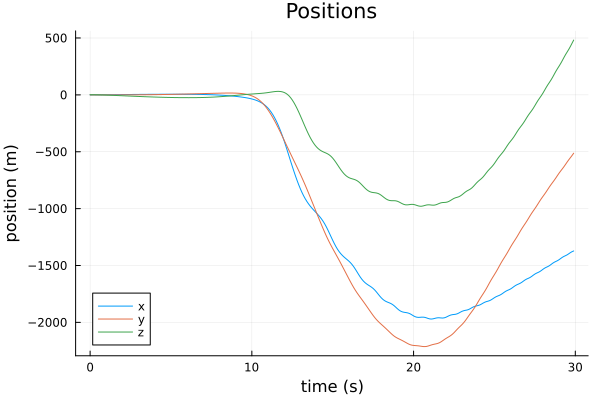

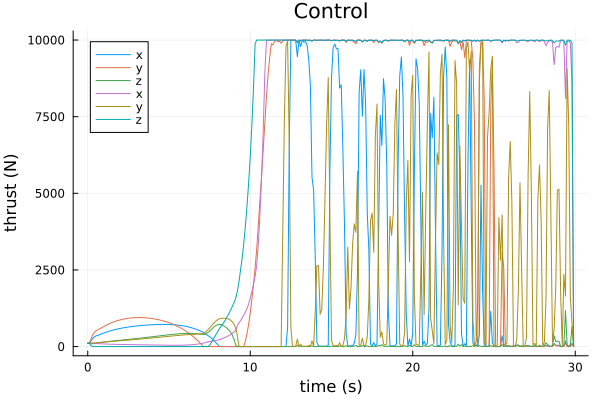

[110.00280000030894 98.48952031328366 186.09729693675843; 110.00280000092526 93.48225486327934 248.75680366549756; 110.00280000022818 111.74060098134328 94.3279476051272; 110.00279999938955 105.5349230523806 112.96275069340336; 110.00279999940794 105.81697373521219 108.7514337953875; 110.00279999966234 118.68095293589379 34.83957629339449]

┌ Info: Listening on: 127.0.0.1:8703, thread id: 1
└ @ HTTP.Servers C:\Users\scott\.julia\packages\HTTP\bDoga\src\Servers.jl:367


┌ Info: MeshCat server started. You can open the visualizer by visiting the following URL in your browser:
│ http://127.0.0.1:8703
└ @ MeshCat C:\Users\scott\.julia\packages\MeshCat\I6NTX\src\visualizer.jl:63


MeshCat.DisplayedVisualizer(MeshCat.CoreVisualizer(MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), UInt8[0x83, 0xa7, 0x6f, 0x70, 0x74, 0x69, 0x6f, 0x6e, 0x73, 0x82  …  0x5f, 0x61, 0x6e, 0x69, 0x6d, 0x61, 0x74, 0x69, 0x6f, 0x6e], Dict{String, MeshCat.SceneTrees.SceneNode}("meshcat" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("drone" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x68, 0x63, 0x61, 0x74, 0x2f, 0x64, 0x72, 0x6f, 0x6e, 0x65], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("base" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x64, 0x72, 0x6f, 0x6e, 0x65, 0x2f, 0x62, 0x61, 0x73, 0x65], UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x64, 0x72, 0x6f, 0x6e, 0x65, 0x2f, 0x62, 0x61, 0x73, 0x65], Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()))))))), Set{HTTP.WebSockets.WebSocket}(), ip"127.0.0.1", 8703))

In [37]:

# Drone parameters
Ixx= 2.331e2
Iyy= 2.322e2
Izz= 4.022e2
model = (mass= 6.728,
    J= Diagonal([Ixx, Iyy, Izz]), 
    gravity= [0,0,-9.81],
    L= 0.5375, 
    kf= 0.1, # constant thrust coefficient 
    km= 0.01, # propeller drag coefficient
    dt= 0.1, #
    α= 0.49, #rad
    β= 0.33 # rad
)

# create our discrete time model 
dt = model.dt
g= 9.81
m= model.mass

n_states = 12
n_inputs = 6

# problem size and reference trajectory 
N = 300
# MPC window size
N_mpc = 60 #20 

# Initialize wind parameters
wind_dynamics = zeros(n_states, 3)
wind_dynamics[4, 1] = 1  # Wind effect on vx
wind_dynamics[5, 2] = 1  # Wind effect on vy
wind_dynamics[6, 3] = 1  # Wind effect on vz
wind_velocity = [0.0, 0, 0] # Intensity of the turbulence
wind_intensity = 0.5

# initial and goal states
x0= [0.0, 0.0, 1.0, 0.0, 0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0]
# xg= [0.0, 0.0, 1.0, 0.0, 0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0]
# Generate hover trajectory for hexrotor
X_ref, U_ref = create_ref_hover(model, N+N_mpc, dt, n_inputs, 1.0)
# Generate equilibrium Point (linearizing about hover)
Xbar = X_ref[1]
Ubar = U_ref[1]

# generate figure 8 trajectory
# X_ref, U_ref = create_fig8(model, N+N_mpc, dt, n_inputs, 5.0)

dX_ref = [(X_ref[i] - Xbar) for i = 1:length(X_ref)]
dU_ref = [(U_ref[i] - Ubar) for i = 1:length(U_ref)]

# bounds on u
u_min = zeros(n_inputs)
u_max = 10000*ones(n_inputs)
du_min = u_min - Ubar
du_max = u_max - Ubar

# MPC Parameters
Q = diagm([1,1,1,
0.1,0.1,0.1,
0.001,0.001,0.001,
0.1,0.1,0.1])
R = diagm(ones(n_inputs)*0.001)

# Linearize system
A = FD.jacobian(dx -> rk4(model, hexrotor_dynamics, dx, Ubar, dt), Xbar)
B = FD.jacobian(du -> rk4(model, hexrotor_dynamics, Xbar, du, dt), Ubar)
C = I(n_states)
D = zeros(n_states, n_inputs)


# sim size and setup 
N_sim = N 
t_vec = 0:dt:((N_sim-1)*dt)
X_sim = [zeros(n_states) for i = 1:N_sim]
X_sim[1] = x0
dX_sim = [zeros(n_states) for i = 1:N_sim]
dX_sim[1] = X_sim[1] - Xbar

U_sim = [zeros(n_inputs) for i = 1:N_sim]
U_sim[1] = U_ref[1]
dU_sim = [zeros(n_inputs) for i = 1:N_sim]
dU_sim[1] = U_sim[1] - Ubar

x_hat = [zeros(n_states) for i = 1:N_sim]
x_hat[1] = X_sim[1]
dX_hat = [zeros(n_states) for i = 1:N_sim]
dX_hat[1] = dX_sim[1]

dxg= 1*dX_ref[N]
measurements = X_sim[1]

# Initialize Kalman Filter parameters
Qkf = I*1
Rkf = I*1
P = I(n_states)


# simulate 
@showprogress "simulating" for i = 1:N_sim-1 
    # given a window of N_mpc timesteps, get current reference trajectory
    dX_ref_tilde = dX_ref[i: (i+ N_mpc-1)] 
    
    # call convex mpc controller with state estimate 
    dU_sim[i] = convex_mpc(A, B, dX_ref_tilde, dX_hat[i], dxg, du_min, du_max, N_mpc, Q, R, wind_dynamics, wind_velocity) 
    dU_sim[i] = clamp.(dU_sim[i], du_min, du_max)
    #u_mpc = convex_mpc(A, B, X_ref_tilde, xi_estimate, u_min, u_max, N_mpc) 
    U_sim[i] = dU_sim[i] + Ubar

    # simulate one step- X_sim is delta x so add xref to the end
    # dX_sim[i+1] = A*(dX_sim[i]) + B*(dU_sim[i])# + rand(n_states) * 0.01
    # X_sim[i+1] = dX_sim[i+1] + Xbar

    X_sim[i+1] = rk4(model, hexrotor_dynamics, X_sim[i], U_sim[i], dt) #+ randn(n_states)*0.001
    X_sim[i+1] = X_sim[i+1] + wind_dynamics*wind_velocity

    dX_sim[i+1] = X_sim[i+1] - Xbar

    # get state estimate
    #x_hat = X_sim[i]#+ 0.01*rand(nx) #state_estimate(X_sim[i], xg)
    dX_hat[i+1], P = kalman_filter(A, B, C, D, Qkf, Rkf, dX_hat[i], P, dU_sim[i], measurements, wind_dynamics, wind_velocity) 

    measurements = dX_sim[i+1] #+ randn(n_states) * 0.01
end

# -------------plotting/animation---------------------------
Xm = mat_from_vec(X_sim)
Um = mat_from_vec(U_sim)
Xref= mat_from_vec(X_ref[1:N_sim-1])
display(plot(t_vec,Xm[1:3,:]',title = "Positions",
            xlabel = "time (s)", ylabel = "position (m)",
            label = ["x" "y" "z"]))
# #plot!(t_vec,Xref[1:3,:]', ls=:dash)

display(plot(t_vec[1:end],Um',title = "Control",
        xlabel = "time (s)", ylabel = "thrust (N)",
            label = ["x" "y" "z"]))


print(Um[:, 1:3])
# Plotting

# true_states_plot = hcat(X_sim...)
# estimated_states_plot = hcat(estimated_states...)
# #U_ref_plot = hcat(U_ref...)
# X_ref_plot = hcat(X_ref...)
# # inputs_plot = hcat(inputs...)
# for i in 1:n_states
#     p = plot(t_vec, true_states_plot[i,:], label="True")
#     plot!(t_vec, estimated_states_plot[i, :], label="Estimated", linestyle=:dash)
#     plot!(t_vec, X_ref_plot[i, 1:N], label = "Reference")
#     title!("State $i")
#     display(p)
# end

######### this would be cool if it worked...
# true_states_plot = mat_from_vec(X_sim...)
# estimated_states_plot = mat_from_vec(x_hat...)
# X_ref_plot = mat_from_vec(X_ref...)
# p = plot(t_vec, true_states_plot[1:3,:]', label="True")
# plot!(t_vec, estimated_states_plot[1:3, :]', label="Estimated", linestyle=:dash)
# plot!(t_vec, X_ref_plot[1:3, :]', label = "Reference")
# title!("State")
# display(p)
##############################


# for i in 1:n_inputs
#     p = plot(time, inputs_plot[i, :], label="MPC Inputs")
#     plot!(time, U_ref_plot[i, 1:N], label = "Reference")
#     title!("Input $i")
#     display(p)
# end

display(animate_hexrotor(X_sim, dt))
# @test norm(X_sim[end] - xg) < 1e-3 # goal 
